# 1. Setup and Load Data

## 1.1. Imports and config GPU usage

In [164]:
import os
import cv2
import imghdr
import itertools

import numpy as np 
import tensorflow as tf
import pandas as pd

from matplotlib import pyplot as plt

In [165]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


## 1.2. Remove dodgy images

In [166]:
# # Setting the path to the directory containing datasets
# data_dir = '../datasets/train_test'

# # List of acceptable image extensions
# image_extensions = ['jpeg','jpg','bmp','png']

# # Looping through each dataset in the data directory
# for dataset in os.listdir(data_dir):
#     # Looping through each image in the current dataset
#     for image in os.listdir(os.path.join(data_dir, dataset)):
#         # Creating the path to the current image
#         image_path = os.path.join(data_dir, dataset, image)
        
#         try:
#             # Reading the image using OpenCV
#             img = cv2.imread(image_path)
#             # Checking the type of the image
#             tip = imghdr.what(image_path)

#             # If the image type is not in the list of acceptable image extensions
#             if tip not in image_extensions:
#                 # Printing a message indicating that the image is not in the list of extensions
#                 print('Image not in extensions list {}'.format(image_path))
#                 # Removing the image
#                 os.remove(image_path)
                
#         except Exception as e:
#             # Printing a message indicating there was an issue with the current image
#             print('Issue with image {}'.format(image_path))

## 1.3 Load data

In [167]:
train_data_dir = '../datasets/train_test/train_images/'
label_csv = '../datasets/train.csv'

# Read train.csv file
images_labels = pd.read_csv(label_csv)

In [168]:
# Encode competition-provided labels 
label_to_id = {
    'healthy': 0,
    'scab': 1,
    'frog_eye_leaf_spot': 2,
    'rust': 3,
    'complex': 4,
    'powdery_mildew': 5,
    'scab frog_eye_leaf_spot complex': 6,
    'scab frog_eye_leaf_spot': 7,
    'frog_eye_leaf_spot complex': 8,
    'rust frog_eye_leaf_spot': 9,
    'powdery_mildew complex': 10,
    'rust complex': 11
}

id_to_label = {value:key for key, value in label_to_id.items()} 

images_labels['labels'] = images_labels['labels'].map(label_to_id)

In [169]:
# Helper functions
def make_path(row):
    return  os.path.join(train_data_dir, row.image)

# Get absolute path for images
images_labels['image'] = images_labels.apply(lambda row: make_path(row), axis=1)

# Look at the dataframe
images_labels.head()

image  labels
0  ../datasets/train_test/train_images/800113bb65...       0
1  ../datasets/train_test/train_images/8002cb321f...       6
2  ../datasets/train_test/train_images/80070f7fb5...       1
3  ../datasets/train_test/train_images/8007751778...       1
4  ../datasets/train_test/train_images/800cbf0ff8...       4

In [170]:
# 6. Helper functions for input pipeline
def decode_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Normalize image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Resize image
    image = tf.image.resize(image, (255, 255))

    return image

def load_image(dict):
    # Load image
    image = tf.io.read_file(dict['image'])
    image = decode_image(image)
    
    # Parse label
    label = dict['labels']
    
    return image, label

# 7. Build data loaders
trainloader = tf.data.Dataset.from_tensor_slices(dict(images_labels))
trainloader = ( trainloader.map(load_image).batch(32) )

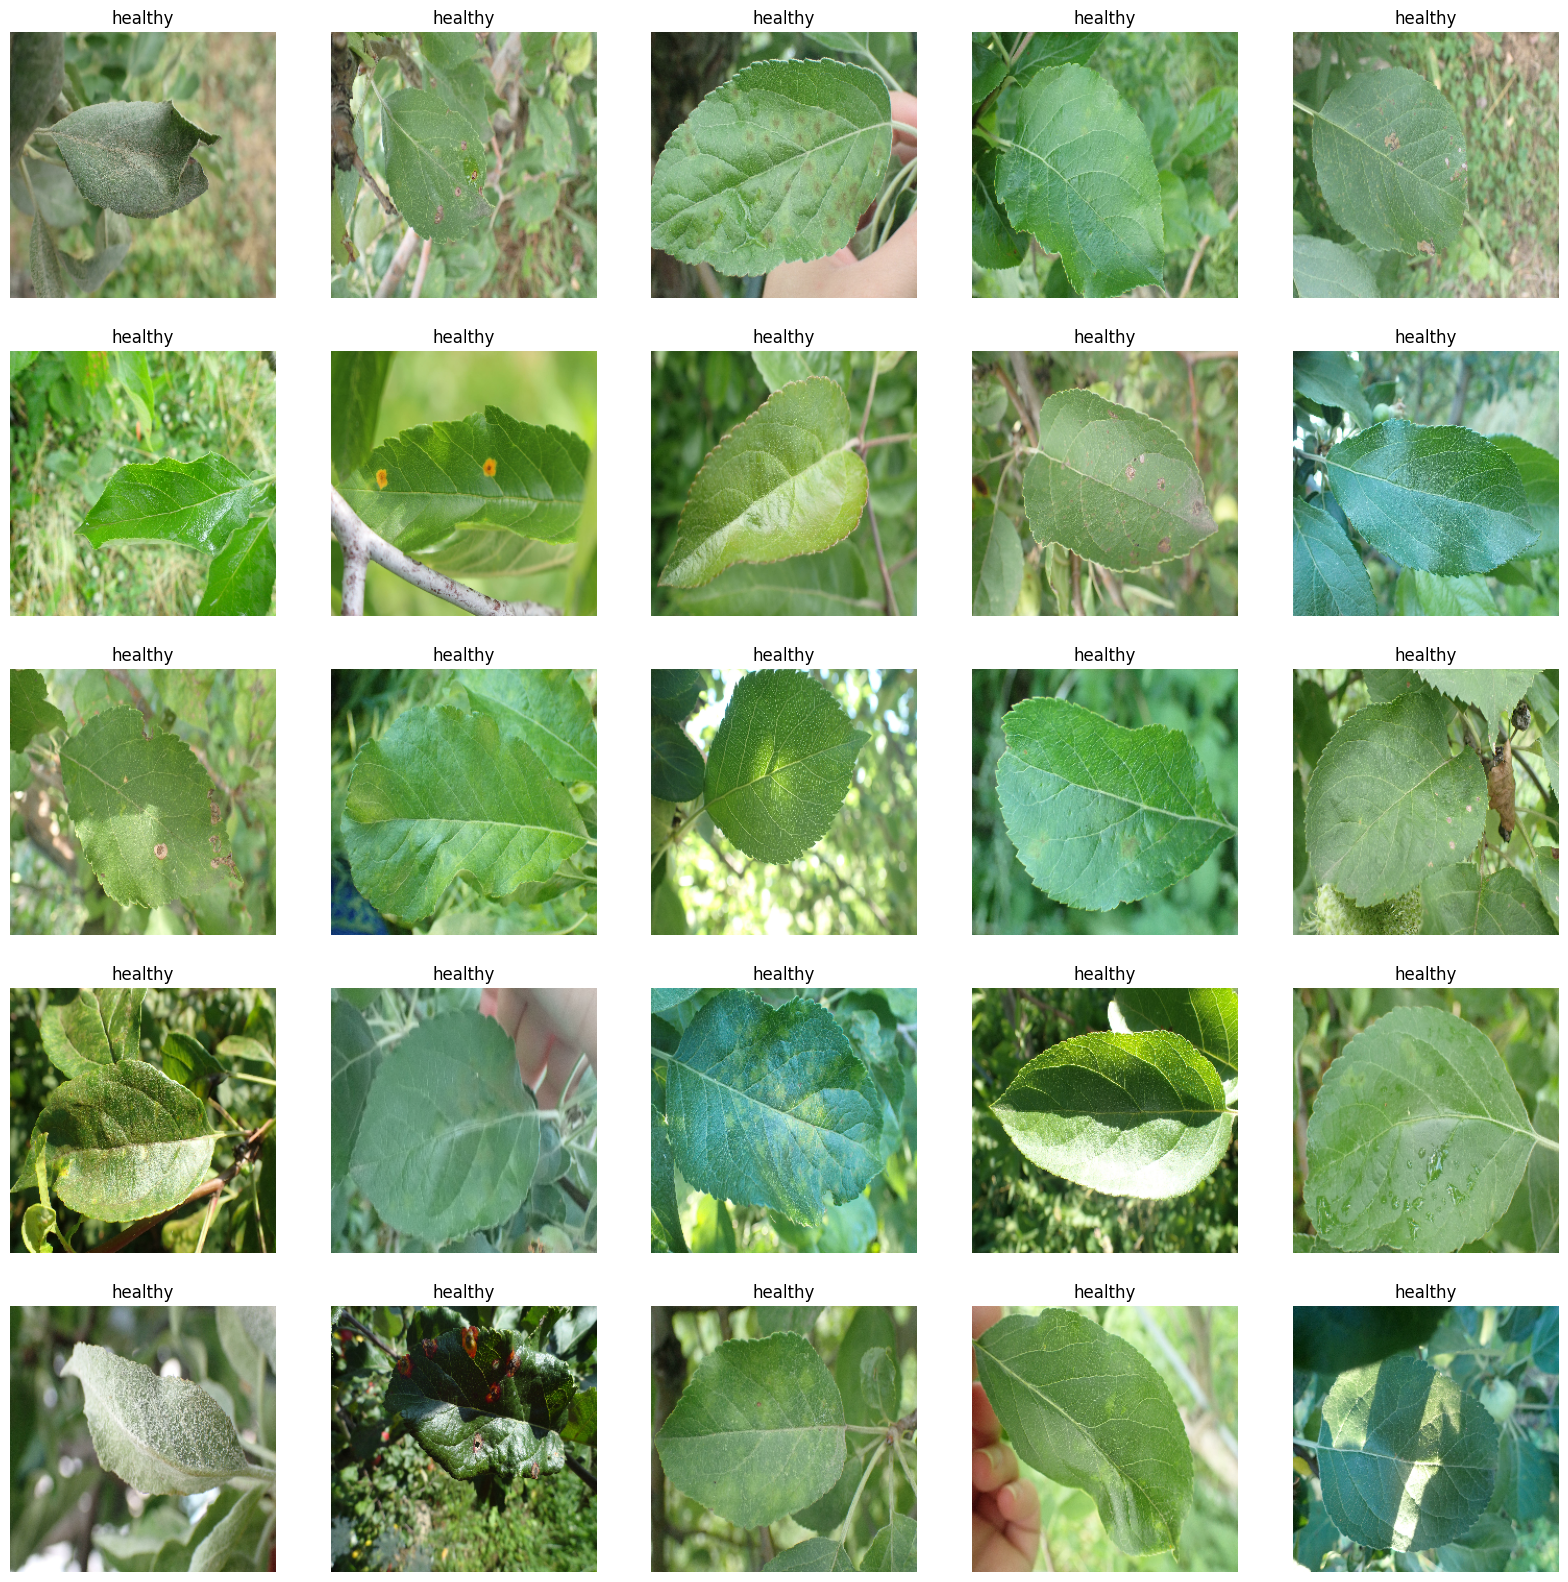

In [172]:
# Data loader sanity check
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(id_to_label[label_batch[18].numpy()])
        plt.axis('off')

image_batch, label_batch = next(iter(trainloader))
show_batch(image_batch, label_batch)

# 2.0. Preprocessing Data

## 2.1. Scale Data